In [1]:
import client
import server
import utils

In [2]:
import importlib
importlib.reload(client)
importlib.reload(server)
importlib.reload(utils)

<module 'utils' from '/Users/gael/Desktop/het-opl/src/utils.py'>

In [3]:
from tqdm.notebook import tqdm

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from vowpalwabbit.sklearn import VW
from sklearn.model_selection import train_test_split

In [4]:
np.random.seed(42)

### Generate data from homogeneous clients

In [5]:
def generate_separated_vectors(n, k, L=1.0, num_vectors=4, max_iter=1000):
    vectors = np.zeros((num_vectors, n))
    for i in range(num_vectors):
        for _ in range(max_iter):
            vector = np.random.rand(n) * 2 * L - L
            if i == 0 or np.all(np.linalg.norm(vectors[:i] - vector, axis=1) >= k):
                vectors[i] = vector
                break
        else:
            raise RuntimeError(f"Failed to generate a vector separated by {k} after {max_iter} iterations.")
    return vectors

def generate_observational_data(num_clients, num_actions, num_features,
                                train_sizes, test_sizes=None):
    if test_sizes is None:
        test_sizes = [10_000] * num_clients

    # Generate action parameters
    found_action_params = False
    while not found_action_params:
        action_params = generate_separated_vectors(num_features, 1, np.sqrt(num_features), 4)
        found_action_params = True
        for i in range(num_actions):
            other_vectors = np.delete(action_params, [i], axis=0)
            if not all(np.linalg.norm(action_params[i] - v) > np.sqrt(num_features) for v in other_vectors):
                found_action_params = False
                
    print("Found action params.")

    data = {}
    aux = {}
    for client_id in range(num_clients):
        # Get num local samples, including test samples
        num_samples = train_sizes[client_id] + test_sizes[client_id]
        
        # Generate local data
        contexts = np.random.normal(loc=0, scale=1, size=(num_samples, num_features)) 
        rewards_vectors = np.zeros((num_samples, num_actions))
        for i in range(num_samples):
            for a in range(num_actions):
                rewards_vectors[i, a] += np.dot(contexts[i], action_params[a])
                if contexts[i][0] > 0:
                    rewards_vectors[i, a] += -np.max([np.dot(contexts[i], action_params[aprime]) for aprime in range(num_actions)])
        # actions = np.random.choice(num_actions, p=[0.7, 0.1, 0.1, 0.1], size=num_samples)
        actions = np.random.choice(num_actions, size=num_samples)
        epsilons = np.random.normal(loc=0, scale=1, size=(num_samples, num_actions))
        noisy_rewards_vectors = rewards_vectors + epsilons
        noisy_rewards = noisy_rewards_vectors[np.arange(num_samples), actions]
        
        # Get local train-test split
        (X_train, X_test,
         A_train, A_test,
         Y_train, Y_test,
         true_costs_train, true_costs_test) = train_test_split(contexts, actions, noisy_rewards, -rewards_vectors,
                                                               train_size=train_sizes[client_id],
                                                               shuffle=False)

        # Compute local AIPW scores
        crossfit_map, mu, e = utils.cross_fit_nuisance_params(X_train, A_train, Y_train, num_actions)
        AIPW_vectors = utils.compute_AIPW_scores(X_train, A_train, Y_train, num_actions, crossfit_map, mu, e)

        # Convert local data to VW format
        vw_data = utils.to_vw_format(X_train, A_train, -AIPW_vectors)

        # Store local data
        data[client_id] = vw_data
        aux[client_id] = {"X_train": X_train, "X_test": X_test,
                          "A_train": A_train, "A_test": A_test,
                          "Y_train": Y_train, "Y_test": Y_test,
                          "true_costs_train": true_costs_train, "true_costs_test": true_costs_test}
    
    return data, aux

In [6]:
NUM_CLIENTS = 4
NUM_ACTIONS = 4
NUM_FEATURES = 10
TRAIN_SIZES = np.array([1, 1, 1, 1]) * 250_000
TEST_SIZES = np.array([1, 1, 1, 1]) * 10_000

# Generate data
data, aux = generate_observational_data(num_clients=NUM_CLIENTS,
                                        num_actions=NUM_ACTIONS,
                                        num_features=NUM_FEATURES,
                                        train_sizes=TRAIN_SIZES,
                                        test_sizes=TEST_SIZES)

Found action params.


### Train optimal model

In [7]:
# Aggregate all data
X_train = []
A_train = []
Y_train = []
true_costs_train = []
true_costs_test = []
X_test = []
for client_id in range(NUM_CLIENTS):
    X_train.extend(aux[client_id]["X_train"])
    A_train.extend(aux[client_id]["A_train"])
    Y_train.extend(aux[client_id]["Y_train"])
    true_costs_train.extend(aux[client_id]["true_costs_train"])
    true_costs_test.extend(aux[client_id]["true_costs_test"])
    X_test.extend(aux[client_id]["X_test"])
X_train = np.array(X_train)
A_train = np.array(A_train)
Y_train = np.array(Y_train)
true_costs_train = np.array(true_costs_train)
true_costs_test = np.array(true_costs_test)
X_test = np.array(X_test)

# Compute AIPW scores
crossfit_map, mu, e = utils.cross_fit_nuisance_params(X_train, A_train, Y_train, NUM_ACTIONS)
noisy_costs_train = -utils.compute_AIPW_scores(X_train, A_train, Y_train, NUM_ACTIONS, crossfit_map, mu, e)
data_train = utils.to_vw_format(X_train, A_train, noisy_costs_train)

# Train model
opt_global_model = VW(csoaa=NUM_ACTIONS,
               convert_to_vw=False,
               convert_labels=False,
               passes=1)
opt_global_model.fit(data_train)

# Evaluate on test data
X_test_vw = utils.to_vw_format(X_test)
regret, opt_reward, reward = utils.compute_regret(X_test_vw, true_costs_test, opt_global_model)
print(f"Aggregate: opt_reward={opt_reward}, reward={reward}, regret={regret}")

Aggregate: opt_reward=3.306222474682597, reward=3.30580807557235, regret=0.0004143991102456278


In [8]:
# Define optimal local models
opt_local_models = {k:opt_global_model for k in range(NUM_CLIENTS)}

### Train local model

In [9]:
def train_local_policy(train_data, sample_size):
    assert len(train_data) >= sample_size
    
    # Train on local data
    model = VW(csoaa=NUM_ACTIONS,
               convert_to_vw=False,
               convert_labels=False,
               passes=1)
    # model.fit(train_data[:sample_size])
    model.fit(random.sample(train_data, sample_size))
    return model

def eval_local_policy(X_test, true_costs, model, opt_model=None):
    # Evaluate on test data
    X_test_vw = utils.to_vw_format(X_test)
    regret, opt_reward, reward = utils.compute_regret(X_test_vw, true_costs, model, opt_model)
    return regret, opt_reward, reward

def eval_random_policy(X_test, true_costs, opt_model=None):
    # Create random policy and evaluate on test data
    class Model():
        def predict(self, X):
            return np.random.choice(NUM_ACTIONS, size=len(X))
        
    X_test_vw = utils.to_vw_format(X_test)
    regret, opt_reward, reward = utils.compute_regret(X_test_vw, true_costs, Model(), opt_model)
    return regret, opt_reward, reward

In [10]:
ss_range = [10, 25, 50, 75, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]

In [11]:
def run_local_training_experiments(data, aux, client_id=0, num_iters=3):
    local_regrets_mean = []
    local_regrets_std = []
    random_regrets_mean = []
    random_regrets_std = []

    for sample_size in tqdm(ss_range):
        local_regret = 0
        random_regret = 0
        local_regret_iters = []
        random_regret_iters = []
        for i in range(num_iters):
            local_model = train_local_policy(data[client_id], sample_size)
            lr, _, _ = eval_local_policy(aux[client_id]["X_test"], aux[client_id]["true_costs_test"], local_model, opt_local_models[client_id])
            rr, _, _ = eval_random_policy(aux[client_id]["X_test"], aux[client_id]["true_costs_test"], opt_local_models[client_id])
            local_regret_iters.append(lr)
            random_regret_iters.append(rr)
        local_regrets_mean.append(np.mean(local_regret_iters))
        local_regrets_std.append(np.std(local_regret_iters))
        random_regrets_mean.append(np.mean(random_regret_iters))
        random_regrets_std.append(np.std(random_regret_iters))
        
    return (np.array(local_regrets_mean),
            np.array(local_regrets_std),
            np.array(random_regrets_mean),
            np.array(random_regrets_std))

In [12]:
local_regrets, local_regrets_std, random_regrets, random_regrets_std = run_local_training_experiments(data, aux, client_id=0, num_iters=3)

  0%|          | 0/13 [00:00<?, ?it/s]

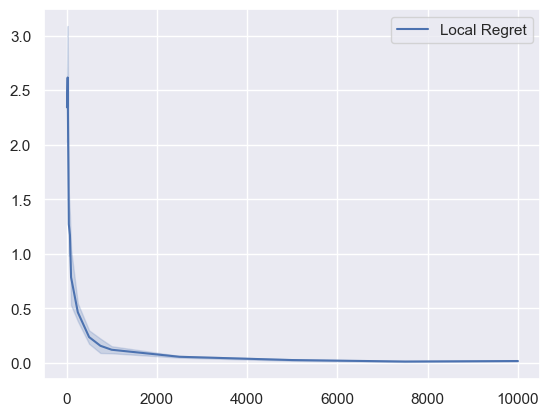

In [13]:
x = ss_range
plt.plot(x, local_regrets, 'b-', label='Local Regret')
plt.fill_between(x, local_regrets - local_regrets_std, local_regrets + local_regrets_std, color='b', alpha=0.2)
plt.legend()
plt.show()

### Train federated model

In [14]:
NUM_ROUNDS = 1

def run_federated_training_experiments(data, aux, sample_size_fns, num_iters=3):

    local_regrets_mean = {k:[] for k in range(NUM_CLIENTS)}
    local_regrets_std = {k:[] for k in range(NUM_CLIENTS)}
    global_regrets_mean = []
    global_regrets_std = []
    
    for sample_size in tqdm(ss_range):
        local_regrets_iters = {k:[] for k in range(NUM_CLIENTS)}
        global_regret_iters = []
        for i in tqdm(range(num_iters)):

            # Subsample data
            data_mod = {}
            aux_mod = {}
            client_weights = []
            for client_id in range(NUM_CLIENTS):
                client_sample_size = sample_size_fns[client_id](sample_size)
                client_weights.append(client_sample_size)

                data_mod[client_id] = random.sample(data[client_id], client_sample_size)
                aux_mod[client_id] = {"X_test": aux[client_id]["X_test"],
                                      "true_costs_test": aux[client_id]["true_costs_test"]}

            client_weights = np.array(client_weights) / np.sum(client_weights)
            
            # Run federated learning
            global_vw = server.run_federated_learning(data_mod, aux_mod,
                                                      opt_global_model, opt_local_models,
                                                      num_features=NUM_FEATURES,
                                                      num_classes=NUM_ACTIONS,
                                                      num_rounds=NUM_ROUNDS,
                                                      num_clients=NUM_CLIENTS,
                                                      client_weights=client_weights)

            gr = global_vw.metrics_distributed["global_regret"][-1][1]
            global_regret_iters.append(gr)
            
            for client_id in range(NUM_CLIENTS):
                lr = global_vw.metrics_distributed["local_regrets"][-1][1][client_id]
                local_regrets_iters[client_id].append(lr)

        global_regrets_mean.append(np.mean(global_regret_iters))
        global_regrets_std.append(np.std(global_regret_iters))
        
        for client_id in range(NUM_CLIENTS):
            local_regrets_mean[client_id].append(np.mean(local_regrets_iters[client_id]))
            local_regrets_std[client_id].append(np.std(local_regrets_iters[client_id]))
            
    global_regrets_mean = np.array(global_regrets_mean)
    global_regrets_std = np.array(global_regrets_std)
    for client_id in range(NUM_CLIENTS):
        local_regrets_mean[client_id] = np.array(local_regrets_mean[client_id])
        local_regrets_std[client_id] = np.array(local_regrets_std[client_id])
        
    return (global_regrets_mean, global_regrets_std,
            local_regrets_mean, local_regrets_std)

In [15]:
%%capture --no-stdout
# sample_size_fns = [lambda n: n // NUM_CLIENTS for _ in range(NUM_CLIENTS)]

client_0_sample_size_fn = lambda n: int(np.log(n))
sample_size_fns = {0: client_0_sample_size_fn,
                   1: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1)),
                   2: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1)),
                   3: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1))}


global_regrets, global_regrets_std, fed_local_regrets, fed_local_regrets_std = run_federated_training_experiments(data, aux, sample_size_fns, num_iters=3)

INFO flwr 2023-05-17 11:44:32,282 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:44:39,336 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 6236941927.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-05-17 11:44:39,338 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-17 11:44:39,339 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-05-17 11:44:40,707 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:44:40,708 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:44:40,708 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:44:40,709 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_get_parameters pid=98859) [Client 2] get_parameters
(launch_and_fit pid=98859) Client 1, training finished for round 1
(launch_and_fit pid=98859) [Client 1] get_parameters


DEBUG flwr 2023-05-17 11:44:41,917 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:44:41,948 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:44:41,950 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=98863) Client 2, training finished for round 1
(launch_and_fit pid=98863) [Client 2] get_parameters
(launch_and_fit pid=98862) Client 3, training finished for round 1
(launch_and_fit pid=98862) [Client 3] get_parameters
(launch_and_fit pid=98858) Client 0, training finished for round 1
(launch_and_fit pid=98858) [Client 0] get_parameters
(launch_and_evaluate pid=98859) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=98863) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=98862) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=98858) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:44:43,100 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:44:43,101 | server.py:144 | FL finished in 2.392037056000163
INFO flwr 2023-05-17 11:44:43,110 | app.py:202 | app_fit: losses_distributed [(1, 4.099784909973686)]
INFO flwr 2023-05-17 11:44:43,111 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.305808075572349)], 'reward': [(1, -0.7939768344013435)], 'global_regret': [(1, 4.099784909973687)], 'local_regrets': [(1, {0: 4.1297177411696895, 1: 4.1027911988299675, 2: 4.013618553376745, 3: 4.153012146518346})]}
INFO flwr 2023-05-17 11:44:43,112 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:44:43,113 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:44:43,119 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:44:51,635 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU':

(launch_and_get_parameters pid=98885) [Client 2] get_parameters
(launch_and_fit pid=98885) Client 0, training finished for round 1
(launch_and_fit pid=98885) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:44:53,839 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:44:53,860 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:44:53,862 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=98883) Client 2, training finished for round 1
(launch_and_fit pid=98883) [Client 2] get_parameters
(launch_and_fit pid=98886) Client 3, training finished for round 1
(launch_and_fit pid=98886) [Client 3] get_parameters
(launch_and_fit pid=98884) Client 1, training finished for round 1
(launch_and_fit pid=98884) [Client 1] get_parameters
(launch_and_evaluate pid=98885) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=98883) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=98886) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=98884) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:44:54,991 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:44:54,992 | server.py:144 | FL finished in 2.344777833999842
INFO flwr 2023-05-17 11:44:54,993 | app.py:202 | app_fit: losses_distributed [(1, 3.4436863587053432)]
INFO flwr 2023-05-17 11:44:54,994 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3058080755723487)], 'reward': [(1, -0.13787828313299805)], 'global_regret': [(1, 3.4436863587053437)], 'local_regrets': [(1, {0: 3.462805438006301, 1: 3.4379627800941117, 2: 3.46687522399552, 3: 3.407101992725442})]}
INFO flwr 2023-05-17 11:44:54,995 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:44:54,996 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:44:55,001 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:45:02,440 | app.py:179 | Flower VCE: Ray initialized with resources: {'obj

(launch_and_get_parameters pid=98904) [Client 0] get_parameters
(launch_and_fit pid=98904) Client 2, training finished for round 1
(launch_and_fit pid=98904) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:45:04,512 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:45:04,533 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:45:04,535 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=98907) Client 0, training finished for round 1
(launch_and_fit pid=98907) [Client 0] get_parameters
(launch_and_fit pid=98903) Client 3, training finished for round 1
(launch_and_fit pid=98903) [Client 3] get_parameters
(launch_and_fit pid=98908) Client 1, training finished for round 1
(launch_and_fit pid=98908) [Client 1] get_parameters
(launch_and_evaluate pid=98904) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=98907) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=98903) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=98908) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:45:05,574 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:45:05,575 | server.py:144 | FL finished in 2.1701704990000508
INFO flwr 2023-05-17 11:45:05,576 | app.py:202 | app_fit: losses_distributed [(1, 3.6595610391124938)]
INFO flwr 2023-05-17 11:45:05,577 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.305808075572349)], 'reward': [(1, -0.35375296354015456)], 'global_regret': [(1, 3.6595610391124938)], 'local_regrets': [(1, {0: 3.6310036343092755, 1: 3.714789243413611, 2: 3.6196310372693383, 3: 3.67282024145775})]}
INFO flwr 2023-05-17 11:45:05,578 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:45:05,579 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:45:05,604 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:45:15,695 | app.py:179 | Flower VCE: Ray initialized with resources: {'ob

(launch_and_get_parameters pid=98930) [Client 1] get_parameters
(launch_and_fit pid=98930) Client 3, training finished for round 1
(launch_and_fit pid=98930) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:45:18,333 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:45:18,353 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:45:18,355 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=98929) Client 2, training finished for round 1
(launch_and_fit pid=98929) [Client 2] get_parameters
(launch_and_fit pid=98924) Client 0, training finished for round 1
(launch_and_fit pid=98924) [Client 0] get_parameters
(launch_and_fit pid=98928) Client 1, training finished for round 1
(launch_and_fit pid=98928) [Client 1] get_parameters
(launch_and_evaluate pid=98930) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=98929) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=98924) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=98928) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-17 11:45:19,729 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:45:19,730 | server.py:144 | FL finished in 2.6444048490000114
INFO flwr 2023-05-17 11:45:19,732 | app.py:202 | app_fit: losses_distributed [(1, 4.020943219646165)]
INFO flwr 2023-05-17 11:45:19,733 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3142660853604817)], 'reward': [(1, -0.7027462751560896)], 'global_regret': [(1, 4.017012360516562)], 'local_regrets': [(1, {0: 4.044528374423788, 1: 3.9797783090290912, 2: 4.031414025106607, 3: 4.028052170025175})]}
INFO flwr 2023-05-17 11:45:19,734 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:45:19,736 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:45:19,744 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:45:29,264 | app.py:179 | Flower VCE: Ray initialized with resources: {'memo

(launch_and_get_parameters pid=98953) [Client 1] get_parameters
(launch_and_fit pid=98953) Client 2, training finished for round 1
(launch_and_fit pid=98953) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:45:31,854 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:45:31,877 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:45:31,879 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=98949) Client 3, training finished for round 1
(launch_and_fit pid=98949) [Client 3] get_parameters
(launch_and_fit pid=98952) Client 1, training finished for round 1
(launch_and_fit pid=98952) [Client 1] get_parameters
(launch_and_fit pid=98954) Client 0, training finished for round 1
(launch_and_fit pid=98954) [Client 0] get_parameters
(launch_and_evaluate pid=98953) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=98949) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=98952) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=98954) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:45:33,685 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:45:33,686 | server.py:144 | FL finished in 3.1934855409999727
INFO flwr 2023-05-17 11:45:33,690 | app.py:202 | app_fit: losses_distributed [(1, 3.128356638979757)]
INFO flwr 2023-05-17 11:45:33,692 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.2948380560395987)], 'reward': [(1, 0.1495313505288263)], 'global_regret': [(1, 3.14530670551077)], 'local_regrets': [(1, {0: 3.026656239793677, 1: 3.1427002867620586, 2: 3.1164315997179646, 3: 3.227638429645327})]}
INFO flwr 2023-05-17 11:45:33,695 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:45:33,697 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:45:33,724 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:45:45,748 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU':

(launch_and_get_parameters pid=98975) [Client 3] get_parameters


INFO flwr 2023-05-17 11:45:47,843 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:45:47,845 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:45:47,846 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:45:47,848 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=98975) Client 0, training finished for round 1
(launch_and_fit pid=98975) [Client 0] get_parameters
(launch_and_fit pid=98972) Client 1, training finished for round 1
(launch_and_fit pid=98972) [Client 1] get_parameters
(launch_and_fit pid=98974) Client 3, training finished for round 1
(launch_and_fit pid=98974) [Client 3] get_parameters
(launch_and_fit pid=98977) Client 2, training finished for round 1
(launch_and_fit pid=98977) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:45:50,345 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:45:50,377 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:45:50,380 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=98974) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=98975) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=98972) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=98977) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:45:53,252 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:45:53,254 | server.py:144 | FL finished in 5.406595905000131
INFO flwr 2023-05-17 11:45:53,257 | app.py:202 | app_fit: losses_distributed [(1, 2.4874046141636352)]
INFO flwr 2023-05-17 11:45:53,260 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.30957100068308)], 'reward': [(1, 0.8264239371668147)], 'global_regret': [(1, 2.4831470635162627)], 'local_regrets': [(1, {0: 2.5129499180478723, 1: 2.48075180991252, 2: 2.473694559138322, 3: 2.4822221695558264})]}
INFO flwr 2023-05-17 11:45:53,262 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:45:53,265 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:45:53,337 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:46:07,007 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:1

(launch_and_get_parameters pid=98996) [Client 1] get_parameters


INFO flwr 2023-05-17 11:46:14,856 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:46:14,858 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:46:14,861 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:46:14,874 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=98996) Client 2, training finished for round 1
(launch_and_fit pid=98996) [Client 2] get_parameters
(launch_and_fit pid=98999) Client 0, training finished for round 1
(launch_and_fit pid=98999) [Client 0] get_parameters
(launch_and_fit pid=99001) Client 1, training finished for round 1
(launch_and_fit pid=99001) [Client 1] get_parameters
(launch_and_fit pid=98997) Client 3, training finished for round 1
(launch_and_fit pid=98997) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:46:57,109 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:46:57,698 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:46:57,763 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=98999) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=98996) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99001) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=98997) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:47:41,547 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:47:41,552 | server.py:144 | FL finished in 86.68699913700016
INFO flwr 2023-05-17 11:47:41,558 | app.py:202 | app_fit: losses_distributed [(1, 1.071964161822634)]
INFO flwr 2023-05-17 11:47:41,573 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.289353046273224)], 'reward': [(1, 2.213350196553291)], 'global_regret': [(1, 1.076002849719935)], 'local_regrets': [(1, {0: 1.0558094102334317, 1: 1.0616008845914464, 2: 1.1070727522715489, 3: 1.0633736001941103})]}
INFO flwr 2023-05-17 11:47:41,577 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:47:41,582 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:47:41,632 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:48:02,564 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU':

(launch_and_get_parameters pid=99043) [Client 0] get_parameters


INFO flwr 2023-05-17 11:48:08,172 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:48:08,177 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:48:08,180 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:48:08,184 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99043) Client 2, training finished for round 1
(launch_and_fit pid=99043) [Client 2] get_parameters
(launch_and_fit pid=99046) Client 3, training finished for round 1
(launch_and_fit pid=99046) [Client 3] get_parameters
(launch_and_fit pid=99045) Client 1, training finished for round 1
(launch_and_fit pid=99045) [Client 1] get_parameters
(launch_and_fit pid=99044) Client 0, training finished for round 1
(launch_and_fit pid=99044) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:48:14,354 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:48:14,421 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:48:14,426 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99043) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99046) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99045) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99044) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:48:20,012 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:48:20,014 | server.py:144 | FL finished in 11.830181181000171
INFO flwr 2023-05-17 11:48:20,017 | app.py:202 | app_fit: losses_distributed [(1, 1.6559138297336955)]
INFO flwr 2023-05-17 11:48:20,020 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.2893530462732246)], 'reward': [(1, 1.6375346582279602)], 'global_regret': [(1, 1.6518183880452568)], 'local_regrets': [(1, {0: 1.6722955964874497, 1: 1.6202295656055299, 2: 1.6760431333939902, 3: 1.655087023447812})]}
INFO flwr 2023-05-17 11:48:20,023 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:48:20,027 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:48:20,051 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:48:33,256 | app.py:179 | Flower VCE: Ray initialized with resources: {'C

(launch_and_get_parameters pid=99078) [Client 1] get_parameters


INFO flwr 2023-05-17 11:48:35,750 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:48:35,751 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:48:35,753 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:48:35,755 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99078) Client 1, training finished for round 1
(launch_and_fit pid=99078) [Client 1] get_parameters
(launch_and_fit pid=99077) Client 2, training finished for round 1
(launch_and_fit pid=99077) [Client 2] get_parameters
(launch_and_fit pid=99080) Client 3, training finished for round 1
(launch_and_fit pid=99080) [Client 3] get_parameters
(launch_and_fit pid=99079) Client 0, training finished for round 1
(launch_and_fit pid=99079) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:48:38,602 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:48:38,636 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:48:38,639 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99078) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99077) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99080) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99079) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:48:41,530 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:48:41,532 | server.py:144 | FL finished in 5.776584402999788
INFO flwr 2023-05-17 11:48:41,536 | app.py:202 | app_fit: losses_distributed [(1, 1.261784036269912)]
INFO flwr 2023-05-17 11:48:41,539 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3184950902545487)], 'reward': [(1, 2.0560540540071326)], 'global_regret': [(1, 1.2624410362474163)], 'local_regrets': [(1, {0: 1.259156036359894, 1: 1.2842479359831067, 2: 1.266271459424496, 3: 1.237460713312151})]}
INFO flwr 2023-05-17 11:48:41,541 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:48:41,544 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:48:41,663 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:48:53,834 | app.py:179 | Flower VCE: Ray initialized with resources: {'objec

(launch_and_get_parameters pid=99104) [Client 3] get_parameters


INFO flwr 2023-05-17 11:48:55,856 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:48:55,857 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:48:55,858 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:48:55,859 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99104) Client 3, training finished for round 1
(launch_and_fit pid=99104) [Client 3] get_parameters
(launch_and_fit pid=99100) Client 0, training finished for round 1
(launch_and_fit pid=99100) [Client 0] get_parameters
(launch_and_fit pid=99101) Client 2, training finished for round 1
(launch_and_fit pid=99101) [Client 2] get_parameters
(launch_and_fit pid=99098) Client 1, training finished for round 1
(launch_and_fit pid=99098) [Client 1] get_parameters


DEBUG flwr 2023-05-17 11:48:58,152 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:48:58,190 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:48:58,193 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99104) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99100) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99101) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99098) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:49:01,457 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:49:01,459 | server.py:144 | FL finished in 5.599237139000024
INFO flwr 2023-05-17 11:49:01,462 | app.py:202 | app_fit: losses_distributed [(1, 0.8665967172489704)]
INFO flwr 2023-05-17 11:49:01,465 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.2886768121924375)], 'reward': [(1, 2.419426797293131)], 'global_regret': [(1, 0.869250014899301)], 'local_regrets': [(1, {0: 0.8564024683819105, 1: 0.8738695476276165, 2: 0.8592823326670576, 3: 0.8768325203192971})]}
INFO flwr 2023-05-17 11:49:01,467 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:49:01,469 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:49:01,486 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:49:12,532 | app.py:179 | Flower VCE: Ray initialized with resources: {'mem

(launch_and_get_parameters pid=99125) [Client 1] get_parameters


INFO flwr 2023-05-17 11:49:14,975 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:49:14,977 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:49:14,979 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:49:14,981 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99125) Client 2, training finished for round 1
(launch_and_fit pid=99125) [Client 2] get_parameters
(launch_and_fit pid=99124) Client 3, training finished for round 1
(launch_and_fit pid=99124) [Client 3] get_parameters
(launch_and_fit pid=99122) Client 0, training finished for round 1
(launch_and_fit pid=99122) [Client 0] get_parameters
(launch_and_fit pid=99127) Client 1, training finished for round 1
(launch_and_fit pid=99127) [Client 1] get_parameters


DEBUG flwr 2023-05-17 11:49:17,501 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:49:17,538 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:49:17,542 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99125) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99124) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99122) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99127) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-17 11:49:21,284 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:49:21,287 | server.py:144 | FL finished in 6.3062267159998555
INFO flwr 2023-05-17 11:49:21,292 | app.py:202 | app_fit: losses_distributed [(1, 0.8623517688797925)]
INFO flwr 2023-05-17 11:49:21,298 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.2886768121924375)], 'reward': [(1, 2.4312931518582808)], 'global_regret': [(1, 0.8573836603341523)], 'local_regrets': [(1, {0: 0.8814397648709359, 1: 0.8506830359603129, 2: 0.872711984752084, 3: 0.844572289935837})]}
INFO flwr 2023-05-17 11:49:21,303 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:49:21,309 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:49:21,368 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:49:34,580 | app.py:179 | Flower VCE: Ray initialized with resources: {'ob

(launch_and_get_parameters pid=99148) [Client 1] get_parameters


INFO flwr 2023-05-17 11:49:38,423 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:49:38,425 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:49:38,427 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:49:38,429 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99148) Client 1, training finished for round 1
(launch_and_fit pid=99148) [Client 1] get_parameters
(launch_and_fit pid=99145) Client 2, training finished for round 1
(launch_and_fit pid=99145) [Client 2] get_parameters
(launch_and_fit pid=99146) Client 3, training finished for round 1
(launch_and_fit pid=99146) [Client 3] get_parameters
(launch_and_fit pid=99147) Client 0, training finished for round 1
(launch_and_fit pid=99147) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:49:42,989 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:49:43,061 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:49:43,065 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99148) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99145) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99146) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99147) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-17 11:49:53,039 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:49:53,043 | server.py:144 | FL finished in 14.613213982999696
INFO flwr 2023-05-17 11:49:53,048 | app.py:202 | app_fit: losses_distributed [(1, 1.2717627081713057)]
INFO flwr 2023-05-17 11:49:53,051 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3038545913019783)], 'reward': [(1, 2.0310441184398433)], 'global_regret': [(1, 1.2728104728621321)], 'local_regrets': [(1, {0: 1.2677370859381298, 1: 1.2347860332509724, 2: 1.287167989310278, 3: 1.2973597241858423})]}
INFO flwr 2023-05-17 11:49:53,054 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:49:53,063 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:49:53,210 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:50:13,734 | app.py:179 | Flower VCE: Ray initialized with resources: {'C

(launch_and_get_parameters pid=99173) [Client 0] get_parameters


INFO flwr 2023-05-17 11:50:20,665 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:50:20,668 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:50:20,670 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:50:20,673 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99173) Client 1, training finished for round 1
(launch_and_fit pid=99173) [Client 1] get_parameters
(launch_and_fit pid=99168) Client 2, training finished for round 1
(launch_and_fit pid=99168) [Client 2] get_parameters
(launch_and_fit pid=99172) Client 3, training finished for round 1
(launch_and_fit pid=99172) [Client 3] get_parameters
(launch_and_fit pid=99167) Client 0, training finished for round 1
(launch_and_fit pid=99167) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:50:28,212 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:50:28,299 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:50:28,306 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99173) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99168) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99172) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99167) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:50:37,419 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:50:37,428 | server.py:144 | FL finished in 16.755294107999816
INFO flwr 2023-05-17 11:50:37,434 | app.py:202 | app_fit: losses_distributed [(1, 0.7203535503038875)]
INFO flwr 2023-05-17 11:50:37,438 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.303706537757277)], 'reward': [(1, 2.5842228600388664)], 'global_regret': [(1, 0.719483677718409)], 'local_regrets': [(1, {0: 0.7234602381091674, 1: 0.7177535490332422, 2: 0.7065780639473205, 3: 0.7336223501258197})]}
INFO flwr 2023-05-17 11:50:37,444 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:50:37,447 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:50:37,477 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:50:58,810 | app.py:179 | Flower VCE: Ray initialized with resources: {'ob

(launch_and_get_parameters pid=99207) [Client 1] get_parameters


INFO flwr 2023-05-17 11:51:05,655 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:51:05,657 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:51:05,659 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:51:05,674 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99207) Client 2, training finished for round 1
(launch_and_fit pid=99207) [Client 2] get_parameters
(launch_and_fit pid=99201) Client 0, training finished for round 1
(launch_and_fit pid=99201) [Client 0] get_parameters
(launch_and_fit pid=99203) Client 3, training finished for round 1
(launch_and_fit pid=99203) [Client 3] get_parameters
(launch_and_fit pid=99200) Client 1, training finished for round 1
(launch_and_fit pid=99200) [Client 1] get_parameters


DEBUG flwr 2023-05-17 11:51:13,059 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:51:13,151 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:51:13,157 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99207) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99201) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99203) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99200) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-17 11:51:22,955 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:51:22,958 | server.py:144 | FL finished in 17.284396453000227
INFO flwr 2023-05-17 11:51:22,971 | app.py:202 | app_fit: losses_distributed [(1, 1.6227332675693809)]
INFO flwr 2023-05-17 11:51:22,974 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.312129789758377)], 'reward': [(1, 1.6848206185076315)], 'global_regret': [(1, 1.6273091712507421)], 'local_regrets': [(1, {0: 1.6063907544216611, 1: 1.6193977086208529, 2: 1.6129140842877945, 3: 1.6522305229472145})]}
INFO flwr 2023-05-17 11:51:22,977 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:51:22,981 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:51:23,009 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:51:39,309 | app.py:179 | Flower VCE: Ray initialized with resources: {'o

(launch_and_get_parameters pid=99227) [Client 0] get_parameters


INFO flwr 2023-05-17 11:51:42,286 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:51:42,288 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:51:42,290 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:51:42,292 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99227) Client 1, training finished for round 1
(launch_and_fit pid=99227) [Client 1] get_parameters
(launch_and_fit pid=99232) Client 0, training finished for round 1
(launch_and_fit pid=99232) [Client 0] get_parameters
(launch_and_fit pid=99233) Client 2, training finished for round 1
(launch_and_fit pid=99233) [Client 2] get_parameters
(launch_and_fit pid=99231) Client 3, training finished for round 1
(launch_and_fit pid=99231) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:51:45,945 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:51:46,001 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:51:46,006 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99232) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99233) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99231) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:51:52,295 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:51:52,297 | server.py:144 | FL finished in 10.005451711000205
INFO flwr 2023-05-17 11:51:52,303 | app.py:202 | app_fit: losses_distributed [(1, 1.1182890600173243)]
INFO flwr 2023-05-17 11:51:52,309 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.2873784427573294)], 'reward': [(1, 2.17603565550347)], 'global_regret': [(1, 1.1113427872538577)], 'local_regrets': [(1, {0: 1.1430971770297054, 1: 1.1116150885489053, 2: 1.099855191786197, 3: 1.1185887827044896})]}
INFO flwr 2023-05-17 11:51:52,312 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:51:52,315 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:51:52,432 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:52:10,739 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU

(launch_and_get_parameters pid=99255) [Client 3] get_parameters


INFO flwr 2023-05-17 11:52:14,809 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:52:14,811 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:52:14,814 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:52:14,816 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99255) Client 1, training finished for round 1
(launch_and_fit pid=99255) [Client 1] get_parameters
(launch_and_fit pid=99257) Client 0, training finished for round 1
(launch_and_fit pid=99257) [Client 0] get_parameters
(launch_and_fit pid=99260) Client 2, training finished for round 1
(launch_and_fit pid=99260) [Client 2] get_parameters
(launch_and_fit pid=99252) Client 3, training finished for round 1
(launch_and_fit pid=99252) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:52:21,418 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:52:21,482 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:52:21,490 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99255) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99252) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99257) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99260) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:52:30,503 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:52:30,505 | server.py:144 | FL finished in 15.688753103000181
INFO flwr 2023-05-17 11:52:30,508 | app.py:202 | app_fit: losses_distributed [(1, 0.32409089053027845)]
INFO flwr 2023-05-17 11:52:30,511 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3127270023888538)], 'reward': [(1, 2.987846133867031)], 'global_regret': [(1, 0.3248808685218197)], 'local_regrets': [(1, {0: 0.3215130676105122, 1: 0.331711987320899, 2: 0.3233130468861277, 3: 0.3198254603035748})]}
INFO flwr 2023-05-17 11:52:30,515 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:52:30,518 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:52:30,561 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:52:48,171 | app.py:179 | Flower VCE: Ray initialized with resources: {'m

(launch_and_get_parameters pid=99283) [Client 1] get_parameters


INFO flwr 2023-05-17 11:52:51,812 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:52:51,814 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:52:51,815 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:52:51,820 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99283) Client 2, training finished for round 1
(launch_and_fit pid=99283) [Client 2] get_parameters
(launch_and_fit pid=99281) Client 3, training finished for round 1
(launch_and_fit pid=99281) [Client 3] get_parameters
(launch_and_fit pid=99285) Client 1, training finished for round 1
(launch_and_fit pid=99285) [Client 1] get_parameters
(launch_and_fit pid=99279) Client 0, training finished for round 1
(launch_and_fit pid=99279) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:52:56,788 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:52:56,838 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:52:56,843 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99283) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99281) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99285) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99279) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:53:05,554 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:53:05,557 | server.py:144 | FL finished in 13.737145155000235
INFO flwr 2023-05-17 11:53:05,562 | app.py:202 | app_fit: losses_distributed [(1, 0.6463099481025997)]
INFO flwr 2023-05-17 11:53:05,566 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3035080053830423)], 'reward': [(1, 2.6587402513173988)], 'global_regret': [(1, 0.6447677540656414)], 'local_regrets': [(1, {0: 0.6513423707495161, 1: 0.6125424784433224, 2: 0.6781786450850669, 3: 0.6431762981324933})]}
INFO flwr 2023-05-17 11:53:05,569 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:53:05,581 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:53:05,647 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:53:19,722 | app.py:179 | Flower VCE: Ray initialized with resources: {'

(launch_and_get_parameters pid=99305) [Client 1] get_parameters


INFO flwr 2023-05-17 11:53:23,078 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:53:23,079 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:53:23,081 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:53:23,084 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99305) Client 3, training finished for round 1
(launch_and_fit pid=99305) [Client 3] get_parameters
(launch_and_fit pid=99309) Client 0, training finished for round 1
(launch_and_fit pid=99309) [Client 0] get_parameters
(launch_and_fit pid=99303) Client 2, training finished for round 1
(launch_and_fit pid=99303) [Client 2] get_parameters
(launch_and_fit pid=99304) Client 1, training finished for round 1
(launch_and_fit pid=99304) [Client 1] get_parameters


DEBUG flwr 2023-05-17 11:53:26,508 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:53:26,563 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:53:26,567 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99305) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99309) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99303) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99304) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:53:32,762 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:53:32,765 | server.py:144 | FL finished in 9.680776415999844
INFO flwr 2023-05-17 11:53:32,769 | app.py:202 | app_fit: losses_distributed [(1, 0.4182588888854754)]
INFO flwr 2023-05-17 11:53:32,774 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3035080053830423)], 'reward': [(1, 2.886939859212006)], 'global_regret': [(1, 0.4165681461710302)], 'local_regrets': [(1, {0: 0.42377604932208585, 1: 0.4016889689581515, 2: 0.42939236598835423, 3: 0.4181781712733099})]}
INFO flwr 2023-05-17 11:53:32,776 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:53:32,779 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:53:33,032 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:53:48,390 | app.py:179 | Flower VCE: Ray initialized with resources: {'

(launch_and_get_parameters pid=99336) [Client 1] get_parameters


INFO flwr 2023-05-17 11:53:51,314 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:53:51,315 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:53:51,318 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:53:51,321 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99336) Client 3, training finished for round 1
(launch_and_fit pid=99336) [Client 3] get_parameters
(launch_and_fit pid=99335) Client 2, training finished for round 1
(launch_and_fit pid=99335) [Client 2] get_parameters
(launch_and_fit pid=99338) Client 1, training finished for round 1
(launch_and_fit pid=99338) [Client 1] get_parameters
(launch_and_fit pid=99334) Client 0, training finished for round 1
(launch_and_fit pid=99334) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:53:54,766 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:53:54,813 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:53:54,817 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99336) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99335) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99338) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99334) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:53:59,530 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:53:59,532 | server.py:144 | FL finished in 8.211493687999791
INFO flwr 2023-05-17 11:53:59,535 | app.py:202 | app_fit: losses_distributed [(1, 0.15440944058863076)]
INFO flwr 2023-05-17 11:53:59,538 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3129712342168722)], 'reward': [(1, 3.1576567979679364)], 'global_regret': [(1, 0.15531443624893335)], 'local_regrets': [(1, {0: 0.1515569859124872, 1: 0.15494368519969046, 2: 0.15244037545012945, 3: 0.15869671579221598})]}
INFO flwr 2023-05-17 11:53:59,541 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:53:59,545 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:53:59,621 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:54:14,124 | app.py:179 | Flower VCE: Ray initialized with resources

(launch_and_get_parameters pid=99361) [Client 3] get_parameters


INFO flwr 2023-05-17 11:54:16,927 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:54:16,929 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:54:16,931 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:54:16,933 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99361) Client 0, training finished for round 1
(launch_and_fit pid=99361) [Client 0] get_parameters
(launch_and_fit pid=99358) Client 3, training finished for round 1
(launch_and_fit pid=99358) [Client 3] get_parameters
(launch_and_fit pid=99356) Client 1, training finished for round 1
(launch_and_fit pid=99356) [Client 1] get_parameters
(launch_and_fit pid=99357) Client 2, training finished for round 1
(launch_and_fit pid=99357) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:54:20,040 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:54:20,089 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:54:20,094 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99361) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99358) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99356) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99357) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:54:24,305 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:54:24,307 | server.py:144 | FL finished in 7.373996693999743
INFO flwr 2023-05-17 11:54:24,310 | app.py:202 | app_fit: losses_distributed [(1, 0.2643989852346994)]
INFO flwr 2023-05-17 11:54:24,313 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3034268149958903)], 'reward': [(1, 3.040111706316123)], 'global_regret': [(1, 0.26331510867976093)], 'local_regrets': [(1, {0: 0.2678152543762141, 1: 0.2755821301933197, 2: 0.2540360965555188, 3: 0.26016245981374486})]}
INFO flwr 2023-05-17 11:54:24,316 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:54:24,319 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:54:24,352 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:54:37,152 | app.py:179 | Flower VCE: Ray initialized with resources: {'

(launch_and_get_parameters pid=99380) [Client 0] get_parameters


INFO flwr 2023-05-17 11:54:39,640 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:54:39,641 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:54:39,643 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:54:39,645 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99380) Client 2, training finished for round 1
(launch_and_fit pid=99380) [Client 2] get_parameters
(launch_and_fit pid=99381) Client 1, training finished for round 1
(launch_and_fit pid=99381) [Client 1] get_parameters
(launch_and_fit pid=99383) Client 0, training finished for round 1
(launch_and_fit pid=99383) [Client 0] get_parameters
(launch_and_fit pid=99378) Client 3, training finished for round 1
(launch_and_fit pid=99378) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:54:42,901 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:54:42,955 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:54:42,958 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99380) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99381) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99383) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99378) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:54:49,697 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:54:49,699 | server.py:144 | FL finished in 10.054009329999644
INFO flwr 2023-05-17 11:54:49,702 | app.py:202 | app_fit: losses_distributed [(1, 0.17309272916364488)]
INFO flwr 2023-05-17 11:54:49,705 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3034268149958903)], 'reward': [(1, 3.1316975704184373)], 'global_regret': [(1, 0.17172924457744998)], 'local_regrets': [(1, {0: 0.17739029450494287, 1: 0.16328471997984578, 2: 0.17686643880239966, 3: 0.17482946336739136})]}
INFO flwr 2023-05-17 11:54:49,707 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:54:49,709 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:54:49,834 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:55:02,774 | app.py:179 | Flower VCE: Ray initialized with resourc

(launch_and_get_parameters pid=99407) [Client 3] get_parameters


INFO flwr 2023-05-17 11:55:05,262 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:55:05,264 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:55:05,266 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:55:05,268 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99407) Client 2, training finished for round 1
(launch_and_fit pid=99407) [Client 2] get_parameters
(launch_and_fit pid=99405) Client 0, training finished for round 1
(launch_and_fit pid=99405) [Client 0] get_parameters
(launch_and_fit pid=99408) Client 3, training finished for round 1
(launch_and_fit pid=99408) [Client 3] get_parameters
(launch_and_fit pid=99406) Client 1, training finished for round 1
(launch_and_fit pid=99406) [Client 1] get_parameters


DEBUG flwr 2023-05-17 11:55:08,564 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:55:08,612 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:55:08,616 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99407) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99405) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99408) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99406) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:55:14,487 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:55:14,490 | server.py:144 | FL finished in 9.222383071999957
INFO flwr 2023-05-17 11:55:14,493 | app.py:202 | app_fit: losses_distributed [(1, 0.1643360313152737)]
INFO flwr 2023-05-17 11:55:14,496 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.322182782522175)], 'reward': [(1, 3.1566491583807847)], 'global_regret': [(1, 0.16553362414138634)], 'local_regrets': [(1, {0: 0.16062448330046172, 1: 0.16564821570042937, 2: 0.16149835815544794, 3: 0.16957306810475573})]}
INFO flwr 2023-05-17 11:55:14,498 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:55:14,501 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:55:14,542 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:55:29,089 | app.py:179 | Flower VCE: Ray initialized with resources:

(launch_and_get_parameters pid=99433) [Client 0] get_parameters


INFO flwr 2023-05-17 11:55:32,146 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:55:32,149 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:55:32,152 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:55:32,155 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99433) Client 1, training finished for round 1
(launch_and_fit pid=99433) [Client 1] get_parameters
(launch_and_fit pid=99432) Client 0, training finished for round 1
(launch_and_fit pid=99432) [Client 0] get_parameters
(launch_and_fit pid=99431) Client 2, training finished for round 1
(launch_and_fit pid=99431) [Client 2] get_parameters
(launch_and_fit pid=99434) Client 3, training finished for round 1
(launch_and_fit pid=99434) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:55:37,229 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:55:37,285 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:55:37,290 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99433) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99432) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99431) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99434) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:55:43,984 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:55:43,987 | server.py:144 | FL finished in 11.832528581999668
INFO flwr 2023-05-17 11:55:43,993 | app.py:202 | app_fit: losses_distributed [(1, 0.326094431758385)]
INFO flwr 2023-05-17 11:55:43,997 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033863034235518)], 'reward': [(1, 2.9759700455592424)], 'global_regret': [(1, 0.32741625786430784)], 'local_regrets': [(1, {0: 0.3219978632482935, 1: 0.3309613842986723, 2: 0.32182577849266275, 3: 0.3295927009939114})]}
INFO flwr 2023-05-17 11:55:44,000 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:55:44,003 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:55:44,041 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:55:59,475 | app.py:179 | Flower VCE: Ray initialized with resources: {

(launch_and_get_parameters pid=99478) [Client 1] get_parameters


INFO flwr 2023-05-17 11:56:02,993 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:56:02,995 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:56:02,997 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:56:02,999 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99478) Client 0, training finished for round 1
(launch_and_fit pid=99478) [Client 0] get_parameters
(launch_and_fit pid=99477) Client 2, training finished for round 1
(launch_and_fit pid=99477) [Client 2] get_parameters
(launch_and_fit pid=99475) Client 1, training finished for round 1
(launch_and_fit pid=99475) [Client 1] get_parameters
(launch_and_fit pid=99471) Client 3, training finished for round 1
(launch_and_fit pid=99471) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:56:07,486 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:56:07,550 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:56:07,557 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99478) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99477) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99475) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99471) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:56:13,726 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:56:13,729 | server.py:144 | FL finished in 10.729140967000149
INFO flwr 2023-05-17 11:56:13,731 | app.py:202 | app_fit: losses_distributed [(1, 0.1492435483972911)]
INFO flwr 2023-05-17 11:56:13,735 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033863034235518)], 'reward': [(1, 3.1540247730080857)], 'global_regret': [(1, 0.1493615304154646)], 'local_regrets': [(1, {0: 0.14887790164675338, 1: 0.1510441999411569, 2: 0.15232024562658886, 3: 0.1447318463746652})]}
INFO flwr 2023-05-17 11:56:13,738 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:56:13,741 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:56:13,987 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:56:28,886 | app.py:179 | Flower VCE: Ray initialized with resources: 

(launch_and_get_parameters pid=99497) [Client 3] get_parameters


INFO flwr 2023-05-17 11:56:31,745 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:56:31,746 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:56:31,748 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:56:31,753 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99497) Client 2, training finished for round 1
(launch_and_fit pid=99497) [Client 2] get_parameters
(launch_and_fit pid=99498) Client 1, training finished for round 1
(launch_and_fit pid=99498) [Client 1] get_parameters
(launch_and_fit pid=99499) Client 3, training finished for round 1
(launch_and_fit pid=99499) [Client 3] get_parameters
(launch_and_fit pid=99501) Client 0, training finished for round 1
(launch_and_fit pid=99501) [Client 0] get_parameters


DEBUG flwr 2023-05-17 11:56:34,946 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:56:34,999 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:56:35,003 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99497) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99498) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99499) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99501) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:56:39,052 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:56:39,054 | server.py:144 | FL finished in 7.300786467999842
INFO flwr 2023-05-17 11:56:39,057 | app.py:202 | app_fit: losses_distributed [(1, 0.10769668039882466)]
INFO flwr 2023-05-17 11:56:39,059 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.284395124532447)], 'reward': [(1, 3.1754355755371515)], 'global_regret': [(1, 0.10895954899529095)], 'local_regrets': [(1, {0: 0.10381481662076371, 1: 0.10850994002125697, 2: 0.10857724069186436, 3: 0.10988472426141362})]}
INFO flwr 2023-05-17 11:56:39,062 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:56:39,065 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:56:39,097 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:56:57,117 | app.py:179 | Flower VCE: Ray initialized with resources

(launch_and_get_parameters pid=99527) [Client 3] get_parameters


INFO flwr 2023-05-17 11:57:02,274 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:57:02,276 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:57:02,279 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:57:02,282 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99527) Client 1, training finished for round 1
(launch_and_fit pid=99527) [Client 1] get_parameters
(launch_and_fit pid=99524) Client 0, training finished for round 1
(launch_and_fit pid=99524) [Client 0] get_parameters
(launch_and_fit pid=99525) Client 2, training finished for round 1
(launch_and_fit pid=99525) [Client 2] get_parameters
(launch_and_fit pid=99522) Client 3, training finished for round 1
(launch_and_fit pid=99522) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:57:07,332 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:57:07,395 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:57:07,399 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99527) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99524) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99525) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99522) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:57:12,754 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:57:12,759 | server.py:144 | FL finished in 10.477550545999748
INFO flwr 2023-05-17 11:57:12,762 | app.py:202 | app_fit: losses_distributed [(1, 0.13473771096256354)]
INFO flwr 2023-05-17 11:57:12,765 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033663488817355)], 'reward': [(1, 3.16837416624022)], 'global_regret': [(1, 0.13499218264151353)], 'local_regrets': [(1, {0: 0.1339555041709605, 1: 0.13502768284758623, 2: 0.13667675389940728, 3: 0.1332909029323002})]}
INFO flwr 2023-05-17 11:57:12,769 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:57:12,772 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:57:12,810 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:57:26,339 | app.py:179 | Flower VCE: Ray initialized with resources: 

(launch_and_get_parameters pid=99546) [Client 1] get_parameters


INFO flwr 2023-05-17 11:57:29,044 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:57:29,046 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:57:29,048 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:57:29,050 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99546) Client 0, training finished for round 1
(launch_and_fit pid=99546) [Client 0] get_parameters
(launch_and_fit pid=99548) Client 1, training finished for round 1
(launch_and_fit pid=99548) [Client 1] get_parameters
(launch_and_fit pid=99551) Client 3, training finished for round 1
(launch_and_fit pid=99551) [Client 3] get_parameters
(launch_and_fit pid=99552) Client 2, training finished for round 1
(launch_and_fit pid=99552) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:57:32,247 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:57:32,298 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:57:32,303 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99546) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99548) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99551) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99552) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-17 11:57:36,522 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:57:36,524 | server.py:144 | FL finished in 7.4742969839999205
INFO flwr 2023-05-17 11:57:36,529 | app.py:202 | app_fit: losses_distributed [(1, 0.14440593042433988)]
INFO flwr 2023-05-17 11:57:36,533 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.2843951245324465)], 'reward': [(1, 3.1402499087798414)], 'global_regret': [(1, 0.1441452157526024)], 'local_regrets': [(1, {0: 0.14520732721531152, 1: 0.14761104106960982, 2: 0.13921868706795243, 3: 0.1455866663444858})]}
INFO flwr 2023-05-17 11:57:36,536 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:57:36,539 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:57:36,775 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:57:51,141 | app.py:179 | Flower VCE: Ray initialized with resources

(launch_and_get_parameters pid=99572) [Client 0] get_parameters


INFO flwr 2023-05-17 11:57:54,308 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:57:54,311 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:57:54,313 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:57:54,316 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99572) Client 2, training finished for round 1
(launch_and_fit pid=99572) [Client 2] get_parameters
(launch_and_fit pid=99570) Client 1, training finished for round 1
(launch_and_fit pid=99570) [Client 1] get_parameters
(launch_and_fit pid=99573) Client 0, training finished for round 1
(launch_and_fit pid=99573) [Client 0] get_parameters
(launch_and_fit pid=99576) Client 3, training finished for round 1
(launch_and_fit pid=99576) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:57:57,539 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:57:57,587 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:57:57,591 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99572) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99570) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99573) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99576) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:58:01,041 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:58:01,043 | server.py:144 | FL finished in 6.727562224999929
INFO flwr 2023-05-17 11:58:01,047 | app.py:202 | app_fit: losses_distributed [(1, 0.06586689125349979)]
INFO flwr 2023-05-17 11:58:01,049 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.322534635729361)], 'reward': [(1, 3.2567130624533958)], 'global_regret': [(1, 0.06582157327596089)], 'local_regrets': [(1, {0: 0.06600438511739205, 1: 0.061756198669626804, 2: 0.06661881269358866, 3: 0.06908816853339164})]}
INFO flwr 2023-05-17 11:58:01,053 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:58:01,057 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:58:01,095 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:58:13,378 | app.py:179 | Flower VCE: Ray initialized with resource

(launch_and_get_parameters pid=99600) [Client 2] get_parameters


INFO flwr 2023-05-17 11:58:15,410 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:58:15,412 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:58:15,413 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:58:15,415 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99600) Client 0, training finished for round 1
(launch_and_fit pid=99600) [Client 0] get_parameters
(launch_and_fit pid=99598) Client 1, training finished for round 1
(launch_and_fit pid=99598) [Client 1] get_parameters
(launch_and_fit pid=99597) Client 2, training finished for round 1
(launch_and_fit pid=99597) [Client 2] get_parameters
(launch_and_fit pid=99599) Client 3, training finished for round 1
(launch_and_fit pid=99599) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:58:17,787 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:58:17,826 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:58:17,830 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99600) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99597) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99599) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 11:58:21,420 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:58:21,422 | server.py:144 | FL finished in 6.007057064000037
INFO flwr 2023-05-17 11:58:21,425 | app.py:202 | app_fit: losses_distributed [(1, 0.023079040909357335)]
INFO flwr 2023-05-17 11:58:21,427 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.284113764944382)], 'reward': [(1, 3.2620391604001258)], 'global_regret': [(1, 0.022074604544254917)], 'local_regrets': [(1, {0: 0.026126481337459324, 1: 0.023069230592819345, 2: 0.023118808396091567, 3: 0.0200016433110591})]}
INFO flwr 2023-05-17 11:58:21,429 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:58:21,431 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:58:21,461 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:58:34,716 | app.py:179 | Flower VCE: Ray initialized with resou

(launch_and_get_parameters pid=99623) [Client 3] get_parameters


INFO flwr 2023-05-17 11:58:37,949 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:58:37,951 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:58:37,953 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:58:37,956 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99623) Client 2, training finished for round 1
(launch_and_fit pid=99623) [Client 2] get_parameters
(launch_and_fit pid=99619) Client 0, training finished for round 1
(launch_and_fit pid=99619) [Client 0] get_parameters
(launch_and_fit pid=99620) Client 1, training finished for round 1
(launch_and_fit pid=99620) [Client 1] get_parameters
(launch_and_fit pid=99622) Client 3, training finished for round 1
(launch_and_fit pid=99622) [Client 3] get_parameters


DEBUG flwr 2023-05-17 11:58:41,240 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:58:41,287 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:58:41,291 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99623) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99620) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99619) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99622) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:58:45,904 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:58:45,907 | server.py:144 | FL finished in 7.951088132000223
INFO flwr 2023-05-17 11:58:45,912 | app.py:202 | app_fit: losses_distributed [(1, 0.06702963071153227)]
INFO flwr 2023-05-17 11:58:45,927 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.284113764944382)], 'reward': [(1, 3.2170711104624203)], 'global_regret': [(1, 0.06704265448196124)], 'local_regrets': [(1, {0: 0.06699011684493952, 1: 0.06557330984864453, 2: 0.061959480659103484, 3: 0.07359561549344157})]}
INFO flwr 2023-05-17 11:58:45,933 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:58:45,941 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:58:46,205 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:58:59,432 | app.py:179 | Flower VCE: Ray initialized with resource

(launch_and_get_parameters pid=99646) [Client 2] get_parameters


INFO flwr 2023-05-17 11:59:01,854 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:59:01,855 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:59:01,858 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:59:01,861 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99646) Client 3, training finished for round 1
(launch_and_fit pid=99646) [Client 3] get_parameters
(launch_and_fit pid=99641) Client 1, training finished for round 1
(launch_and_fit pid=99641) [Client 1] get_parameters
(launch_and_fit pid=99647) Client 0, training finished for round 1
(launch_and_fit pid=99647) [Client 0] get_parameters
(launch_and_fit pid=99648) Client 2, training finished for round 1
(launch_and_fit pid=99648) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:59:04,653 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:59:04,694 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:59:04,698 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99646) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99641) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99647) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99648) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 11:59:07,932 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:59:07,934 | server.py:144 | FL finished in 6.073429708999811
INFO flwr 2023-05-17 11:59:07,937 | app.py:202 | app_fit: losses_distributed [(1, 0.02773867427991163)]
INFO flwr 2023-05-17 11:59:07,941 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033222565568066)], 'reward': [(1, 3.275974720971343)], 'global_regret': [(1, 0.027347535585461706)], 'local_regrets': [(1, {0: 0.028919648598902944, 1: 0.027673010434632595, 2: 0.029173167745256228, 3: 0.025188870340854753})]}
INFO flwr 2023-05-17 11:59:07,943 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:59:07,945 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:59:08,065 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:59:20,433 | app.py:179 | Flower VCE: Ray initialized with reso

(launch_and_get_parameters pid=99666) [Client 1] get_parameters


INFO flwr 2023-05-17 11:59:22,437 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:59:22,438 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:59:22,440 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:59:22,442 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99666) Client 0, training finished for round 1
(launch_and_fit pid=99666) [Client 0] get_parameters
(launch_and_fit pid=99669) Client 3, training finished for round 1
(launch_and_fit pid=99669) [Client 3] get_parameters
(launch_and_fit pid=99670) Client 1, training finished for round 1
(launch_and_fit pid=99670) [Client 1] get_parameters
(launch_and_fit pid=99671) Client 2, training finished for round 1
(launch_and_fit pid=99671) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:59:24,846 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:59:24,881 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:59:24,885 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99666) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99671) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99669) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99670) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-17 11:59:27,587 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:59:27,589 | server.py:144 | FL finished in 5.147093997999946
INFO flwr 2023-05-17 11:59:27,592 | app.py:202 | app_fit: losses_distributed [(1, 0.0386248442212675)]
INFO flwr 2023-05-17 11:59:27,593 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.2840084527568676)], 'reward': [(1, 3.246395537243446)], 'global_regret': [(1, 0.03761291551342276)], 'local_regrets': [(1, {0: 0.04168018452273111, 1: 0.03837491440108637, 2: 0.037950147657145224, 3: 0.03649413030410733})]}
INFO flwr 2023-05-17 11:59:27,595 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:59:27,597 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:59:27,639 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 11:59:39,384 | app.py:179 | Flower VCE: Ray initialized with resources

(launch_and_get_parameters pid=99691) [Client 2] get_parameters


INFO flwr 2023-05-17 11:59:41,636 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 11:59:41,637 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 11:59:41,638 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 11:59:41,640 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99691) Client 1, training finished for round 1
(launch_and_fit pid=99691) [Client 1] get_parameters
(launch_and_fit pid=99692) Client 0, training finished for round 1
(launch_and_fit pid=99692) [Client 0] get_parameters
(launch_and_fit pid=99690) Client 3, training finished for round 1
(launch_and_fit pid=99690) [Client 3] get_parameters
(launch_and_fit pid=99694) Client 2, training finished for round 1
(launch_and_fit pid=99694) [Client 2] get_parameters


DEBUG flwr 2023-05-17 11:59:44,229 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 11:59:44,270 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 11:59:44,273 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99691) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99692) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99690) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99694) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 11:59:47,265 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 11:59:47,267 | server.py:144 | FL finished in 5.627170911000121
INFO flwr 2023-05-17 11:59:47,271 | app.py:202 | app_fit: losses_distributed [(1, 0.029154356060291944)]
INFO flwr 2023-05-17 11:59:47,273 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033222565568066)], 'reward': [(1, 3.274178774499708)], 'global_regret': [(1, 0.029143482057095965)], 'local_regrets': [(1, {0: 0.029187188195545496, 1: 0.0302667372283198, 2: 0.028132617097518988, 3: 0.029030881719783498})]}
INFO flwr 2023-05-17 11:59:47,277 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 11:59:47,281 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 11:59:47,524 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 12:00:00,508 | app.py:179 | Flower VCE: Ray initialized with resou

(launch_and_get_parameters pid=99716) [Client 1] get_parameters


INFO flwr 2023-05-17 12:00:03,157 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 12:00:03,159 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 12:00:03,161 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 12:00:03,163 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99716) Client 0, training finished for round 1
(launch_and_fit pid=99716) [Client 0] get_parameters
(launch_and_fit pid=99714) Client 2, training finished for round 1
(launch_and_fit pid=99714) [Client 2] get_parameters
(launch_and_fit pid=99712) Client 3, training finished for round 1
(launch_and_fit pid=99712) [Client 3] get_parameters
(launch_and_fit pid=99718) Client 1, training finished for round 1
(launch_and_fit pid=99718) [Client 1] get_parameters


DEBUG flwr 2023-05-17 12:00:06,838 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 12:00:06,887 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 12:00:06,893 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99716) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99714) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99712) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99718) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 12:00:12,014 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 12:00:12,016 | server.py:144 | FL finished in 8.853800843000045
INFO flwr 2023-05-17 12:00:12,020 | app.py:202 | app_fit: losses_distributed [(1, 0.018617603246858107)]
INFO flwr 2023-05-17 12:00:12,023 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033169207413646)], 'reward': [(1, 3.2850433585514476)], 'global_regret': [(1, 0.018273562189914758)], 'local_regrets': [(1, {0: 0.01965414960524226, 1: 0.017572631287109543, 2: 0.019737584367154386, 3: 0.017506047727926233})]}
INFO flwr 2023-05-17 12:00:12,025 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 12:00:12,028 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 12:00:12,192 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 12:00:26,879 | app.py:179 | Flower VCE: Ray initialized with res

(launch_and_get_parameters pid=99743) [Client 0] get_parameters


INFO flwr 2023-05-17 12:00:30,032 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 12:00:30,034 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 12:00:30,036 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 12:00:30,040 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99743) Client 3, training finished for round 1
(launch_and_fit pid=99743) [Client 3] get_parameters
(launch_and_fit pid=99740) Client 0, training finished for round 1
(launch_and_fit pid=99740) [Client 0] get_parameters
(launch_and_fit pid=99742) Client 1, training finished for round 1
(launch_and_fit pid=99742) [Client 1] get_parameters
(launch_and_fit pid=99737) Client 2, training finished for round 1
(launch_and_fit pid=99737) [Client 2] get_parameters


DEBUG flwr 2023-05-17 12:00:34,074 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 12:00:34,124 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 12:00:34,128 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99743) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99740) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99742) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99737) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 12:00:38,695 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 12:00:38,699 | server.py:144 | FL finished in 8.658819399000095
INFO flwr 2023-05-17 12:00:38,704 | app.py:202 | app_fit: losses_distributed [(1, 0.010287116568964166)]
INFO flwr 2023-05-17 12:00:38,707 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033169207413646)], 'reward': [(1, 3.292964015031018)], 'global_regret': [(1, 0.010352905710343958)], 'local_regrets': [(1, {0: 0.010088903322195556, 1: 0.009777796821593876, 2: 0.011364879645875734, 3: 0.009916886486191495})]}
INFO flwr 2023-05-17 12:00:38,709 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 12:00:38,711 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 12:00:38,918 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 12:00:55,645 | app.py:179 | Flower VCE: Ray initialized with res

(launch_and_get_parameters pid=99767) [Client 0] get_parameters


INFO flwr 2023-05-17 12:00:59,978 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 12:00:59,981 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 12:00:59,986 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 12:00:59,989 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99767) Client 1, training finished for round 1
(launch_and_fit pid=99767) [Client 1] get_parameters
(launch_and_fit pid=99765) Client 0, training finished for round 1
(launch_and_fit pid=99765) [Client 0] get_parameters
(launch_and_fit pid=99764) Client 2, training finished for round 1
(launch_and_fit pid=99764) [Client 2] get_parameters
(launch_and_fit pid=99761) Client 3, training finished for round 1
(launch_and_fit pid=99761) [Client 3] get_parameters


DEBUG flwr 2023-05-17 12:01:05,402 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 12:01:05,460 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 12:01:05,465 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99767) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99761) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99764) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99765) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-17 12:01:11,275 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 12:01:11,278 | server.py:144 | FL finished in 11.289191667000068
INFO flwr 2023-05-17 12:01:11,284 | app.py:202 | app_fit: losses_distributed [(1, 0.020355137872098934)]
INFO flwr 2023-05-17 12:01:11,287 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033169207413646)], 'reward': [(1, 3.2819243960355537)], 'global_regret': [(1, 0.021392524705808012)], 'local_regrets': [(1, {0: 0.017229640135664873, 1: 0.023027371247555464, 2: 0.02056242025450549, 3: 0.020601119850669907})]}
INFO flwr 2023-05-17 12:01:11,294 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 12:01:11,297 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 12:01:11,821 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 12:01:27,261 | app.py:179 | Flower VCE: Ray initialized with re

(launch_and_get_parameters pid=99785) [Client 1] get_parameters


INFO flwr 2023-05-17 12:01:30,933 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 12:01:30,936 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 12:01:30,938 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 12:01:30,942 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99785) Client 3, training finished for round 1
(launch_and_fit pid=99785) [Client 3] get_parameters
(launch_and_fit pid=99788) Client 0, training finished for round 1
(launch_and_fit pid=99788) [Client 0] get_parameters
(launch_and_fit pid=99789) Client 2, training finished for round 1
(launch_and_fit pid=99789) [Client 2] get_parameters
(launch_and_fit pid=99791) Client 1, training finished for round 1
(launch_and_fit pid=99791) [Client 1] get_parameters


DEBUG flwr 2023-05-17 12:01:35,892 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 12:01:35,955 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 12:01:35,961 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99785) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99789) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99791) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99788) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-17 12:01:41,912 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 12:01:41,915 | server.py:144 | FL finished in 10.973957113999859
INFO flwr 2023-05-17 12:01:41,920 | app.py:202 | app_fit: losses_distributed [(1, 0.013341760509097784)]
INFO flwr 2023-05-17 12:01:41,924 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.283947028546689)], 'reward': [(1, 3.2704871775049047)], 'global_regret': [(1, 0.013459851041784338)], 'local_regrets': [(1, {0: 0.012986208796862658, 1: 0.013748008672304494, 2: 0.013091352317912364, 3: 0.013541472249311619})]}
INFO flwr 2023-05-17 12:01:41,927 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 12:01:41,930 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 12:01:42,034 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 12:01:55,871 | app.py:179 | Flower VCE: Ray initialized with re

(launch_and_get_parameters pid=99822) [Client 0] get_parameters


DEBUG flwr 2023-05-17 12:01:58,447 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99822) Client 3, training finished for round 1
(launch_and_fit pid=99822) [Client 3] get_parameters
(launch_and_fit pid=99826) Client 0, training finished for round 1
(launch_and_fit pid=99826) [Client 0] get_parameters
(launch_and_fit pid=99828) Client 1, training finished for round 1
(launch_and_fit pid=99828) [Client 1] get_parameters
(launch_and_fit pid=99825) Client 2, training finished for round 1
(launch_and_fit pid=99825) [Client 2] get_parameters


DEBUG flwr 2023-05-17 12:02:01,321 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 12:02:01,365 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 12:02:01,369 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99822) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99825) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99828) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=99826) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-17 12:02:05,543 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 12:02:05,545 | server.py:144 | FL finished in 7.097734811000009
INFO flwr 2023-05-17 12:02:05,549 | app.py:202 | app_fit: losses_distributed [(1, 0.013713661935776276)]
INFO flwr 2023-05-17 12:02:05,552 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3226631913877647)], 'reward': [(1, 3.309009432320086)], 'global_regret': [(1, 0.013653759067677358)], 'local_regrets': [(1, {0: 0.013894019893656758, 1: 0.013818771007654966, 2: 0.014202207664099456, 3: 0.012939649177693923})]}
INFO flwr 2023-05-17 12:02:05,554 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 12:02:05,556 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-17 12:02:05,645 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2023-05-17 12:02:18,438 | app.py:179 | Flower VCE: Ray initialized with res

(launch_and_get_parameters pid=99855) [Client 0] get_parameters


INFO flwr 2023-05-17 12:02:20,753 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-17 12:02:20,755 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-17 12:02:20,756 | server.py:101 | FL starting
DEBUG flwr 2023-05-17 12:02:20,758 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=99855) Client 0, training finished for round 1
(launch_and_fit pid=99855) [Client 0] get_parameters
(launch_and_fit pid=99858) Client 3, training finished for round 1
(launch_and_fit pid=99858) [Client 3] get_parameters
(launch_and_fit pid=99857) Client 1, training finished for round 1
(launch_and_fit pid=99857) [Client 1] get_parameters
(launch_and_fit pid=99859) Client 2, training finished for round 1
(launch_and_fit pid=99859) [Client 2] get_parameters


DEBUG flwr 2023-05-17 12:02:23,411 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-17 12:02:23,447 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-17 12:02:23,450 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=99859) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=99855) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=99858) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=99857) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-17 12:02:27,748 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-17 12:02:27,750 | server.py:144 | FL finished in 6.991433505999794
INFO flwr 2023-05-17 12:02:27,752 | app.py:202 | app_fit: losses_distributed [(1, 0.018021640674993303)]
INFO flwr 2023-05-17 12:02:27,754 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 3.3033152523315055)], 'reward': [(1, 3.2849635056121294)], 'global_regret': [(1, 0.018351746719372758)], 'local_regrets': [(1, {0: 0.017027744156550003, 1: 0.018647268615225903, 2: 0.019609712960573556, 3: 0.016801836967623735})]}
INFO flwr 2023-05-17 12:02:27,756 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-17 12:02:27,759 | app.py:205 | app_fit: metrics_centralized {}


In [28]:
client_id = 0

# Apply moving average smoothing
window_size = 1
local_regrets_smooth = np.convolve(local_regrets, np.ones(window_size) / window_size, mode='same')
local_regrets_std_smooth = np.convolve(local_regrets_std, np.ones(window_size) / window_size, mode='same')

global_regrets_smooth = np.convolve(global_regrets, np.ones(window_size) / window_size, mode='same')
global_regrets_std_smooth = np.convolve(global_regrets_std, np.ones(window_size) / window_size, mode='same')

fed_local_regrets_smooth = np.convolve(fed_local_regrets[client_id], np.ones(window_size) / window_size, mode='same')
# window_size=4
fed_local_regrets_std_smooth = np.convolve(fed_local_regrets_std[client_id], np.ones(window_size) / window_size, mode='same')

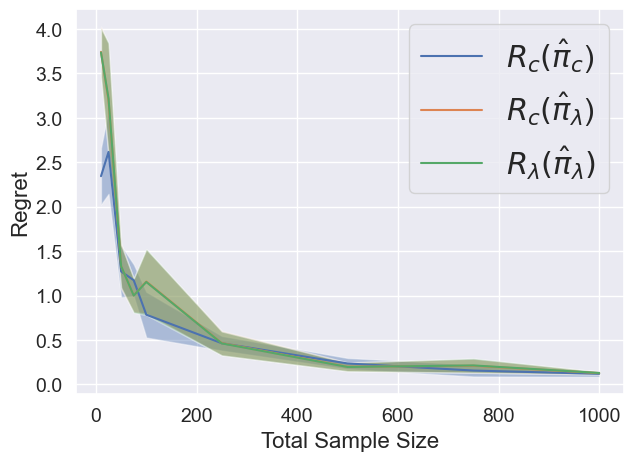

In [29]:
client_id = 0
k1 = 0
k2 = 9
x = ss_range

c=5
plt.rcParams['figure.figsize'] = [c*np.sqrt(2), c*1]
plt.plot(x[k1:k2], local_regrets_smooth[k1:k2], label=r'$R_c(\hat{\pi}_c$)')
plt.fill_between(x[k1:k2], local_regrets_smooth[k1:k2] - local_regrets_std_smooth[k1:k2], local_regrets_smooth[k1:k2] + local_regrets_std_smooth[k1:k2], alpha=0.4)

# plt.plot([sample_size_fns[0](n) for n in x], global_regrets, label="Global model, global regret, local ss")

plt.plot(x[k1:k2], fed_local_regrets_smooth[k1:k2], label=r'$R_c(\hat{\pi}_\lambda$)')
plt.fill_between(x[k1:k2], fed_local_regrets_smooth[k1:k2] - fed_local_regrets_std_smooth[k1:k2], fed_local_regrets_smooth[k1:k2] + fed_local_regrets_std_smooth[k1:k2], alpha=0.4)

plt.plot(x[k1:k2], global_regrets_smooth[k1:k2], label=r'$R_\lambda(\hat{\pi}_\lambda)$')
plt.fill_between(x[k1:k2], global_regrets_smooth[k1:k2] - global_regrets_std_smooth[k1:k2], global_regrets_smooth[k1:k2] + global_regrets_std_smooth[k1:k2], alpha=0.4)

plt.xlabel('Total Sample Size', fontsize=16)
plt.ylabel('Regret', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=22)
# plt.show()


# plt.savefig('./data/homogeneous.png', dpi=300)